# Version notes:

Notebook series 07x:
- Summarize coverage by market
    - num (or pct) days without data within grid of 7-day LOS x 30, 45, 60, 90-days 'til departure
    - avg coverage for 1, 2, ... 7 -day trips across 30, 45, 60, 90 days
    - etc

Subversions:
- c: use more-final code; dev plots (bar chart - market vs coverage)

In [1]:
from functools import reduce
import datetime
from calendar import Calendar
import argparse

import pyspark
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

In [2]:
# for notebook
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

pd.options.mode.chained_assignment = None

In [3]:
# =============================

# VARIABLES & ARGUMENTS
# ----------------
input_dir = "/user/kendra.frederick/shop_vol/encoded/markets/v2"
APP_NAME = "KF-ShopGrid-Jupyter"

In [4]:
# SET UP SPARK
# ----------------
run_mode = "python" 

if run_mode == "python":
    conf1 = pyspark.SparkConf().setAll([
        ("spark.app.name", APP_NAME),
#         ("spark.master","yarn"),
        ("spark.driver.memory","20g"),
#         ("spark.executor.memory", "10g"),
#         ("spark.executor.instances", 5),
#         ("spark.executor.cores", "5"),
        ('spark.sql.crossJoin.enabled', True),
        ('spark.sql.shuffle.partitions', 8) # added this after
        ])
    spark = SparkSession.builder.config(conf = conf1).getOrCreate()
elif run_mode == "spark-submit":
    spark = SparkSession.builder.appName(APP_NAME).getOrCreate()
else:
    pass

In [5]:
spark.sparkContext.applicationId

'local-1662574190038'

# define dates

In [6]:
# assign args to vars
max_days_til_dept = 120 # args.days_til_dept
max_stay_duration = 30 #args.length_of_stay

shop_start_str = "2022-08-01" 
shop_end_str = "2022-08-31" 
# shop_start_str = args.shop_start
# shop_end_str = args.shop_end

missing_search_days_str = ["2022-08-15", "2022-08-16", "2022-08-17", "2022-08-18"]
# missing_search_days_str = [] #args.missing_dates or []
num_missing_days = len(missing_search_days_str)

search_start = datetime.datetime.strptime(shop_start_str, "%Y-%m-%d").date()
search_end = datetime.datetime.strptime(shop_end_str, "%Y-%m-%d").date()
num_search_days = (search_end - search_start).days + 1
num_search_days_adj = num_search_days - num_missing_days

# OUTBOUND DEPARTURE DATES
min_dept_dt = search_start #+ datetime.timedelta(days=1) # filters out same-day searches; include them?
max_dept_dt = search_end + datetime.timedelta(days=max_days_til_dept)
max_return_dt = max_dept_dt + datetime.timedelta(days=max_stay_duration)

# load data

Trying to not rely on these:

In [7]:
# date_enum_path = "/user/kendra.frederick/shop_grid/dates_cross_shop_aug_no_missing"
# date_cross_df = spark.read.parquet(date_enum_path)

# date_enum_path2 = "/user/kendra.frederick/shop_grid/dates_cross_shop_aug_120dtd"
# date_df_missing_removed = spark.read.parquet(date_enum_path2)

# date_cross_df.count(), date_df_missing_removed.count()

In [8]:
# load markets to analyze
markets_path = "/user/kendra.frederick/shop_grid/archive/markets.csv"
markets_df = spark.read.csv(markets_path, header=True)
# print("Analyzing {} markets".format(markets_df.count()))

temp = markets_df.select("market_key_decoded").collect()
market_list = [x["market_key_decoded"] for x in temp]

markets_df = markets_df.withColumnRenamed("market_key_decoded", "market")

In [9]:
# load "input" data -- aggregated volume counts across shopping days
df = spark.read.parquet(input_dir)

df = df.withColumn("market", 
    F.concat_ws("-", F.col("origin_decoded"), F.col("dest_decoded")))

# In a perfect world, shouldn't need to do this; input data is derived from markets.
# However, this list has been changed, so join vs. current list 
# to "clean up" input data
df_join = df.join(F.broadcast(markets_df), on="market", how="inner")

# convert Dept dates (which are strings) to datetime
df_join.registerTempTable("data")
df_join = spark.sql("""
    SELECT *,
        TO_DATE(CAST(UNIX_TIMESTAMP(CAST(outDeptDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS outDeptDt_dt,
        TO_DATE(CAST(UNIX_TIMESTAMP(CAST(inDeptDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS inDeptDt_dt,
        TO_DATE(CAST(UNIX_TIMESTAMP(CAST(searchDt AS string), 'yyyyMMdd') AS TIMESTAMP)) AS searchDt_dt
    FROM data
""")

# filter on dates & round-trip
df_filt = (df_join
            .filter(F.col("outDeptDt_dt").between(min_dept_dt, max_dept_dt))
            # Note: when we filter on stay duration below, this also
            # effectively accomplishes filtering on round-trip == 1
            .filter(F.col("round_trip") == 1)
        )

I moved this here, but then either need to include them in the group-by, or re-compute them. Argh

In [10]:
df_filt = df_filt.withColumn('stay_duration',
                F.datediff(
                    F.col('inDeptDt_dt'), F.col('outDeptDt_dt'))
                )
# Note this effectively filters out null stay durations, which are one-way trips
df_filt = df_filt.filter(F.col('stay_duration').between(0, max_stay_duration))

df_filt = df_filt.withColumn('days_til_dept',
                F.datediff(
                    F.col('outDeptDt_dt'), F.col('searchDt_dt'))
                )
df_filt = df_filt.filter(F.col('days_til_dept').between(0, max_days_til_dept))

## groupby agg

In [11]:
# BY DEPARTURE DATE (dpt)
dpt_df = (df_filt
            .orderBy("searchDt_dt")
            .groupBy(["market", 
                        "outDeptDt_dt", "stay_duration", 
                        ])
            .agg(
                F.countDistinct("searchDt_dt").alias("num_shop_days"),
            )
            .repartition("market")
)
dpt_df.cache()

overlap_end = max_dept_dt - datetime.timedelta(days=max_stay_duration)


dpt_df = (dpt_df.withColumn("expected_num_shop_days", 
                           F.when(F.col("outDeptDt_dt") <= search_end,
                                  F.datediff(F.col("outDeptDt_dt"), F.lit(search_start)) + 1)
                           .otherwise(F.when(F.col("outDeptDt_dt") >= overlap_end,
                                      F.datediff(F.lit(max_dept_dt), F.col("outDeptDt_dt")) + 1)
                            .otherwise(F.lit(num_search_days))
                           ))
                .withColumn("pct_shop_coverage", F.col("num_shop_days")/F.col("expected_num_shop_days"))
)

In [12]:
dpt_df.show(10)

+-------+------------+-----------+-------------+-------------+----------------------+------------------+
| market|outDeptDt_dt|inDeptDt_dt|num_shop_days|stay_duration|expected_num_shop_days| pct_shop_coverage|
+-------+------------+-----------+-------------+-------------+----------------------+------------------+
|LHR-DXB|  2022-11-29| 2022-12-05|           27|            6|                    31|0.8709677419354839|
|LHR-DXB|  2022-10-21| 2022-10-28|           27|            7|                    31|0.8709677419354839|
|LHR-IST|  2022-08-13| 2022-08-28|           13|           15|                    13|               1.0|
|LHR-IST|  2022-08-23| 2022-08-25|           19|            2|                    23|0.8260869565217391|
|LHR-BKK|  2022-11-29| 2022-12-08|           17|            9|                    31|0.5483870967741935|
|LHR-DXB|  2022-10-19| 2022-10-24|           27|            5|                    31|0.8709677419354839|
|LHR-IST|  2022-09-09| 2022-09-26|           25|       

In [13]:
# BY DAYS TIL DEPT
dtd_df = (df_filt
            .groupBy(["market", 
                        "days_til_dept", "stay_duration", 
                        ])
            .agg(F.countDistinct("searchDt_dt").alias("obs_num_days"))
            .withColumn("pct_shop_coverage", F.col("obs_num_days") / num_search_days)
            .withColumn("pct_shop_coverage_adj", F.col("obs_num_days") / num_search_days_adj)           
            .repartition("market")
          )
dtd_df.cache()

DataFrame[market: string, days_til_dept: int, stay_duration: int, obs_num_days: bigint, pct_shop_coverage: double, pct_shop_coverage_adj: double]

In [14]:
dtd_df.show(10)

+-------+-------------+-------------+------------+-------------------+---------------------+
| market|days_til_dept|stay_duration|obs_num_days|  pct_shop_coverage|pct_shop_coverage_adj|
+-------+-------------+-------------+------------+-------------------+---------------------+
|LHR-BKK|           39|           26|          23| 0.7419354838709677|   0.8518518518518519|
|LHR-IST|           79|            8|          24| 0.7741935483870968|   0.8888888888888888|
|LHR-BKK|            4|           18|          26| 0.8387096774193549|   0.9629629629629629|
|LHR-DXB|           70|            2|          18| 0.5806451612903226|   0.6666666666666666|
|LHR-DXB|           47|            0|          24| 0.7741935483870968|   0.8888888888888888|
|LHR-IST|           17|           24|          12| 0.3870967741935484|   0.4444444444444444|
|LHR-IST|           97|           28|           5|0.16129032258064516|  0.18518518518518517|
|LHR-IST|           73|            5|          26| 0.8387096774193549|

In [15]:
def plot_by_dept_dt(market, cnt_df):
    market_pdf = cnt_df.filter(F.col('market') == market).toPandas()

    pvt = market_pdf.pivot(index="stay_duration", 
                            columns="outDeptDt_dt", 
                            values="pct_shop_coverage")

    plt.figure(figsize=(15,12))

    with sns.axes_style("white"):
        sns.heatmap(pvt, cmap='Greens', square=True,
                    vmin=0, vmax=1,
                    cbar_kws={'label': '% coverage',
                            'shrink': 0.25});
        plt.title(f"Coverage (% of days with a shop) - {market}");
        plt.ylabel("stay duration (days)")
        plt.xlabel("departure date");

In [16]:
def plot_by_days_til_dept(market, cnt_df):
    market_pdf = cnt_df.filter(F.col('market') == market).toPandas()

    pvt = market_pdf.pivot(index="stay_duration", 
                            columns="days_til_dept", 
                            values="pct_shop_coverage_adj")

    plt.figure(figsize=(15,12))

    with sns.axes_style("white"):
        sns.heatmap(pvt, cmap='Greens', square=True,
                    vmin=0, vmax=1,
                    cbar_kws={'label': '% coverage',
                            'shrink': 0.25});
        plt.title(f"Coverage (% expected shopping days) - {market}");
        plt.ylabel("stay duration (days)")
        plt.xlabel("days until departure");

# now, summarize

In [37]:
# # define dtd + LOS filters
# los1 = (F.col("stay_duration") == 1)
# los3 = (F.col("stay_duration") == 3)
# los7 = (F.col("stay_duration") == 7)

# dtd1 = (F.col("days_til_dept") == 1)
# dtd7 = (F.col("days_til_dept") == 7)
# dtd14 = (F.col("days_til_dept") == 14)
# dtd30 = (F.col("days_til_dept") == 30)
# dtd45 = (F.col("days_til_dept") == 45)
# dtd60 = (F.col("days_til_dept") == 60)

# los_list = [los1, los3, los7]
# dtd_list = [dtd1, dtd7, dtd14, dtd30, dtd45, dtd60]

# from itertools import combinations, permutations, product

# filter_list = [x & y for x,y in list(product(los_list, dtd_list))]

In [18]:
los_list = [1, 3, 7]
dtd_list = [1, 3, 7, 14, 30]

In [17]:
def get_data_col_name(los, dtd):
    return f"los_{los}_dtd_{dtd}"

If we want to generate all combinations and analyze at once

In [27]:
df_summary = dtd_df.select('market').distinct()

for los in los_list:
    for dtd in dtd_list:
        filt_dtd_agg = dtd_df.filter(
            (F.col("stay_duration") == los) & (F.col("days_til_dept") == dtd)
        )
        new_col_name = get_data_col_name(los, dtd)
        filt_dtd_agg = filt_dtd_agg.withColumnRenamed("pct_shop_coverage_adj", new_col_name)
        df_summary = df_summary.join(filt_dtd_agg.select('market', new_col_name), on='market')

In [28]:
df_summary.show(10)

+-------+-----------+------------------+------------------+------------------+------------------+-----------+------------------+-----------+------------+------------------+-----------+------------------+-----------+------------+------------+
| market|los_1_dtd_1|       los_1_dtd_3|       los_1_dtd_7|      los_1_dtd_14|      los_1_dtd_30|los_3_dtd_1|       los_3_dtd_3|los_3_dtd_7|los_3_dtd_14|      los_3_dtd_30|los_7_dtd_1|       los_7_dtd_3|los_7_dtd_7|los_7_dtd_14|los_7_dtd_30|
+-------+-----------+------------------+------------------+------------------+------------------+-----------+------------------+-----------+------------+------------------+-----------+------------------+-----------+------------+------------+
|LHR-BKK|        1.0|0.8888888888888888|0.9259259259259259|0.9259259259259259|0.8518518518518519|        1.0|0.9629629629629629|        1.0|         1.0|0.9629629629629629|        1.0|               1.0|        1.0|         1.0|         1.0|
|LHR-IST|        1.0|           

In [29]:
pdf_summary = df_summary.toPandas()

In [30]:
len(pdf_summary)

30

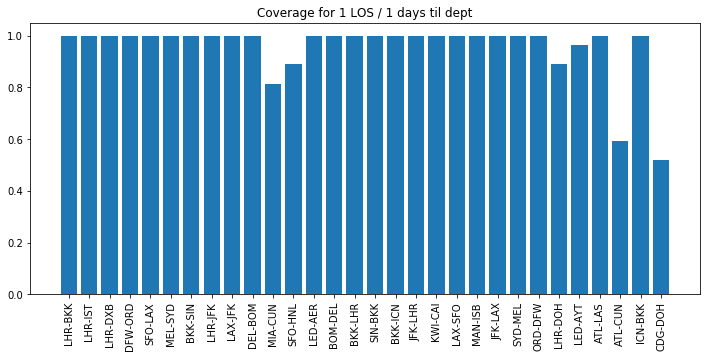

In [33]:
los = 1
dtd = 1

xs = range(30)
plt.figure(figsize=(12,5))
plt.bar(xs, pdf_summary[get_data_col_name(los, dtd)])
plt.xticks(xs, pdf_summary['market'], rotation=90)
plt.title(f"Coverage for {los}-day stay / {dtd} days til dept");

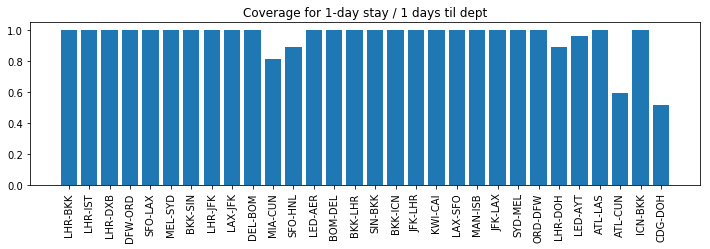

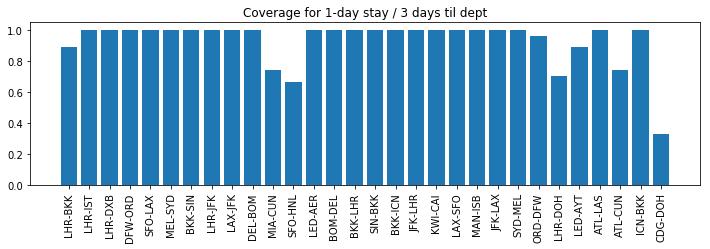

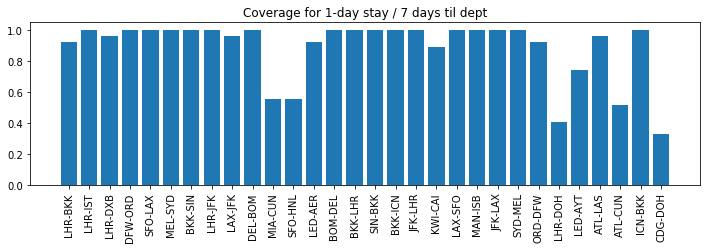

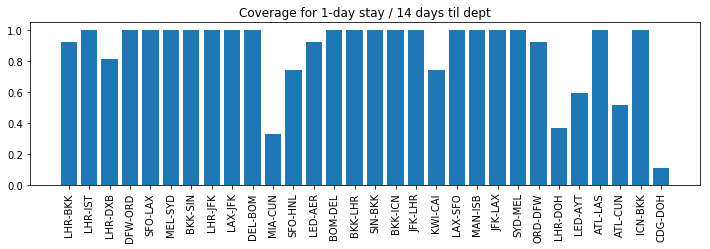

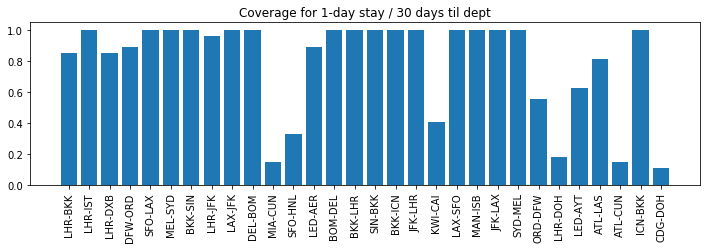

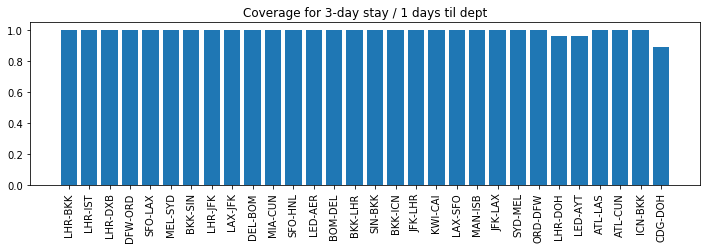

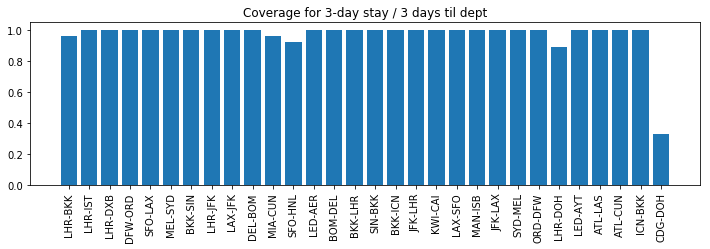

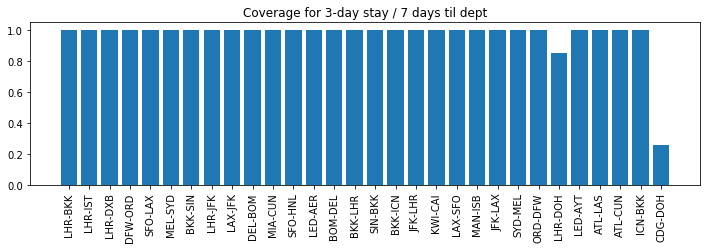

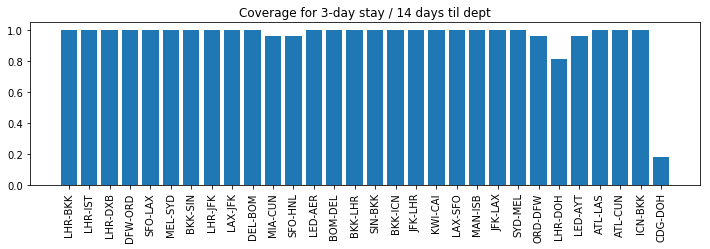

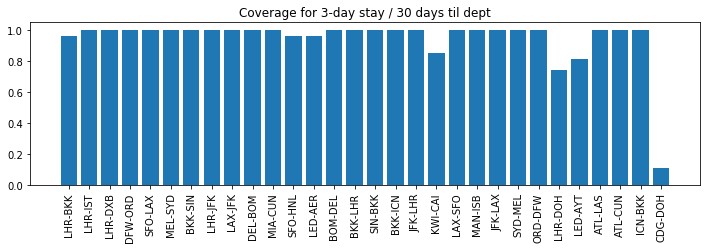

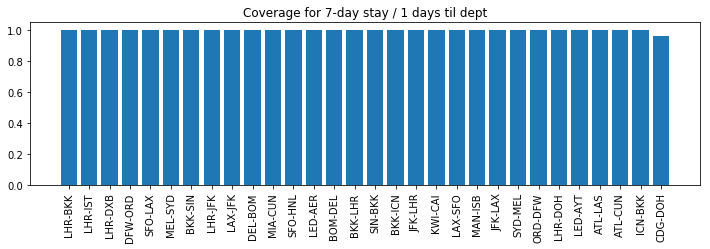

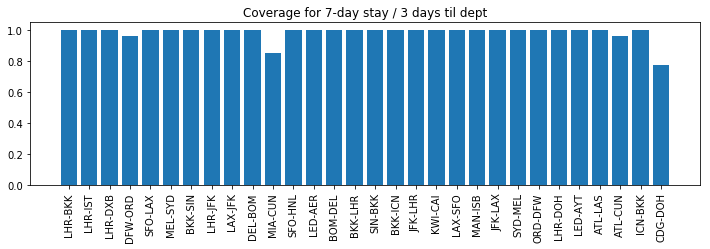

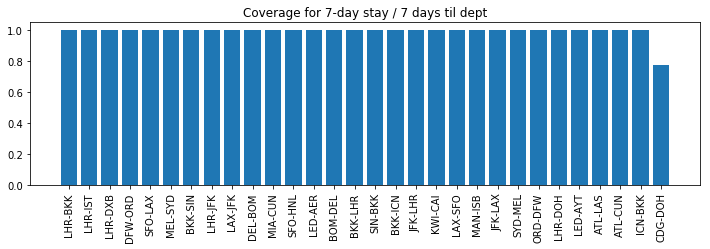

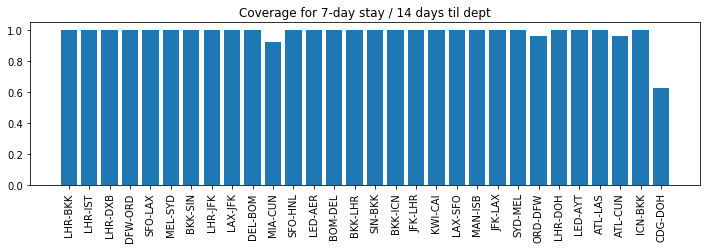

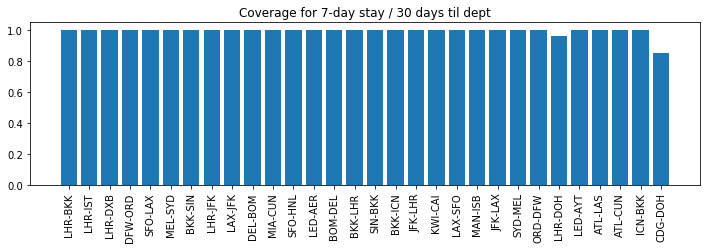

In [34]:
for los in los_list:
    for dtd in dtd_list:
        xs = range(30)
        plt.figure(figsize=(12,3))
        plt.bar(xs, pdf_summary[get_data_col_name(los, dtd)])
        plt.xticks(xs, pdf_summary['market'], rotation=90)
        plt.title(f"Coverage for {los}-day stay / {dtd} days til dept");

In [37]:
list(zip(los_list, dtd_list))

[(1, 1), (3, 3), (7, 7)]

In [38]:
los_list

[1, 3, 7]

In [46]:
dtd_list

[1, 3, 7, 14, 30]

In [43]:
from itertools import product

In [44]:
for (los, dtd) in list(product(los_list, dtd_list)):
    print(los, dtd)

1 1
1 3
1 7
1 14
1 30
3 1
3 3
3 7
3 14
3 30
7 1
7 3
7 7
7 14
7 30


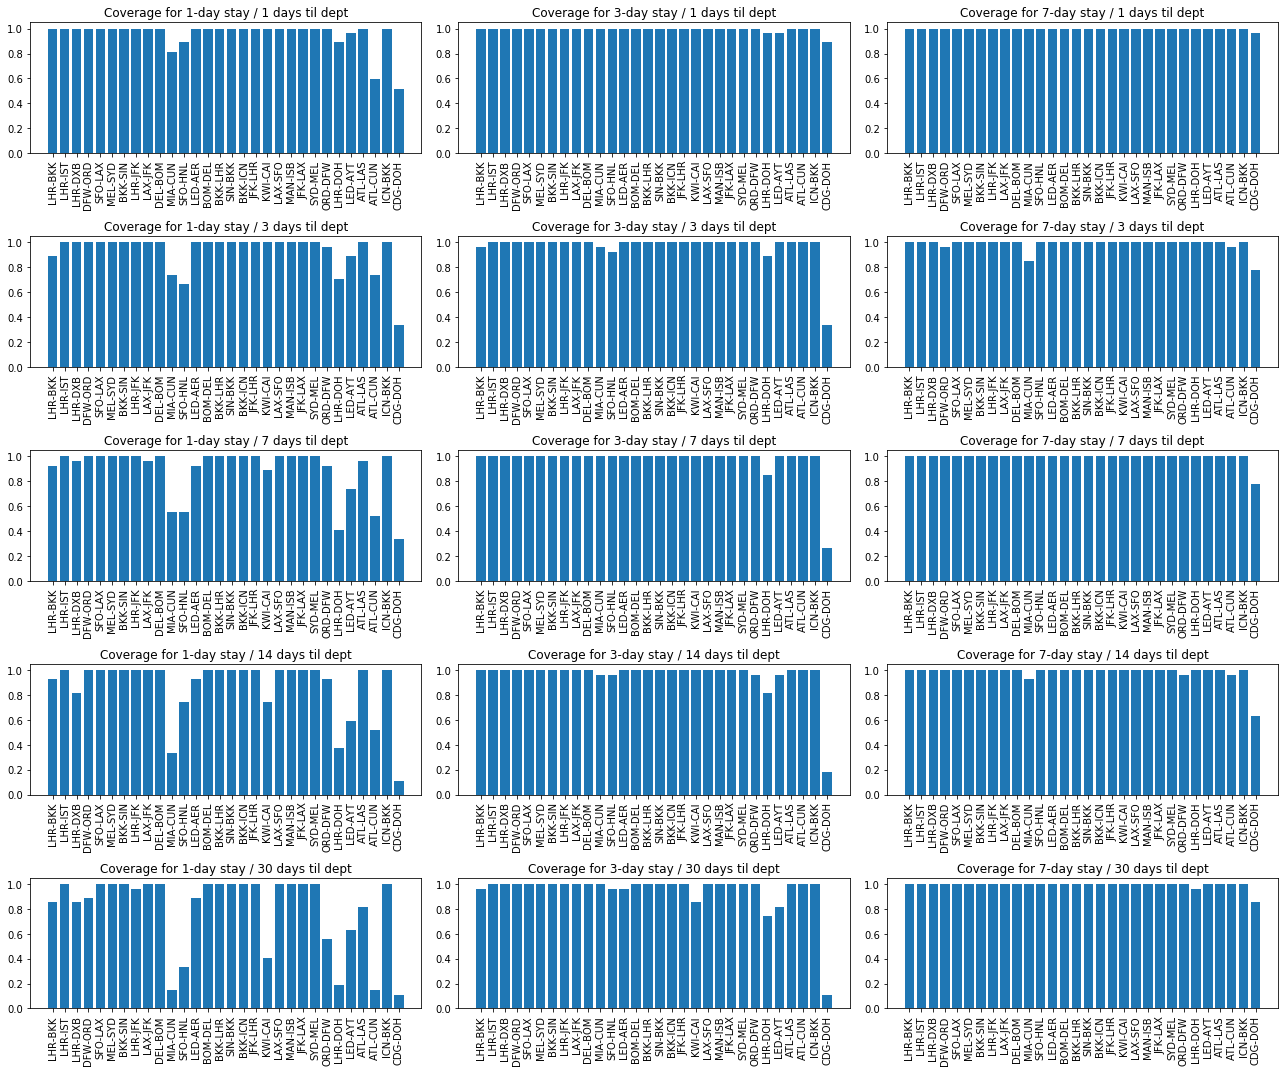

In [49]:
nc = len(los_list)
nr = len(dtd_list)
fig, _ = plt.subplots(nr, nc, sharey=True, figsize=(18, nr*3))

i = 0
# for (los, dtd) in list(product(los_list, dtd_list)):
for dtd in dtd_list:
    for los in los_list:
        i += 1
        plt.subplot(nr, nc, i)
        plt.bar(xs, pdf_summary[get_data_col_name(los, dtd)])
        plt.xticks(xs, pdf_summary['market'], rotation=90)
        plt.title(f"Coverage for {los}-day stay / {dtd} days til dept");

fig.tight_layout()

out_dir = "./output/07_summary/"
file_name = "by-days-til-dept"
plt.savefig(out_dir + file_name + ".png", format="png")

In [50]:
spark.stop()

Next steps
- use patterns to programatically ID "destinations" (e.g. CUN, HNL). they tend to have poor coverage for shorter stays (1 day)